# Predicting lung cancer survival time by OWKIN

https://challengedata.ens.fr/challenges/33

Save and load model
https://github.com/automl/auto-sklearn/issues/5

### Problem

- supervised survival prediction problem
- predict the survival time of a patient (remaining days to live) from one three-dimensional CT scan (grayscale image) and a set of pre-extracted quantitative imaging features, as well as clinical data

### Import

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

import autosklearn.regression

import pickle

# concordance index (C-index)
from metrics_t9gbvr2 import cindex

### Data

- x_train : data_Q0G7b5t
- y_train : output_VSVxRFU.csv
- x_test : data_9Cbe5hx

In [2]:
data_folder_path = "../data"
training_folder_path = os.path.join(data_folder_path, "data_Q0G7b5t")
test_folder_path = os.path.join(data_folder_path, "data_9Cbe5hx")

training_ct_scan_names = [os.path.join(root, file_name) for root, _, file_names in os.walk(training_folder_path)\
                          for file_name in file_names if file_name.endswith('.npz')]

test_ct_scan_names = [os.path.join(root, file_name) for root, _, file_names in os.walk(test_folder_path)\
                      for file_name in file_names if file_name.endswith('.npz')]

print("Number of training ct scans : {}".format(len(training_ct_scan_names)))
print("Number of test ct scans : {}".format(len(test_ct_scan_names)))

training_features_path = os.path.join(training_folder_path, "features")
test_features_path = os.path.join(test_folder_path, "features")

submission_example_file_path = "../random_submission_example"
my_submission_path = "../my_submission"
best_model_path = "../best_model"
best_model_name = "best_model.pickle"

Number of training ct scans : 300
Number of test ct scans : 125


In [3]:
archive = np.load(training_ct_scan_names[0])
scan = archive['scan']
mask = archive['mask']
# scan.shape equals mask.shape
print("scan.shape", scan.shape)
print("mask.shape", mask.shape)

scan.shape (92, 92, 92)
mask.shape (92, 92, 92)


In [4]:
df_train_output = pd.read_csv(os.path.join(data_folder_path, "output_VSVxRFU.csv"), index_col=0)
p0 = df_train_output.loc[202]
print("p0.Event", p0.Event) # prints 1 or 0
print("p0.SurvivalTime", p0.SurvivalTime)
# prints time to event (time to death or time to last known alive) in days

p0.Event 0
p0.SurvivalTime 1378


In [5]:
df_train_output.sample(5)

,SurvivalTime,Event
PatientID,,
345,210,1
130,2600,0
211,1190,0
18,454,1
422,315,0


### Interpretation

(`1=death observed`, `0=escaped from study`)

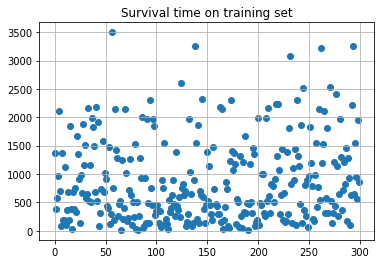

In [6]:
plt.figure()
plt.scatter(np.arange(len(df_train_output)), df_train_output["SurvivalTime"])
plt.grid()
plt.title("Survival time on training set")
plt.show()

## Load data

In [7]:
def load_data(features_path):
    file_name = os.path.join(features_path, "clinical_data.csv")
    df_clinical_data = pd.read_csv(file_name, delimiter=',', index_col=0)
    print("Nb rows in clinical_data : {}".format(len(df_clinical_data)))

    file_name = os.path.join(features_path, "radiomics.csv")
    df_radiomics = pd.read_csv(file_name, delimiter=',', index_col=0, skiprows=[0,2], header=[0])
    df_radiomics.index.name = "PatientID"
    print("Nb rows in radiomics : {}".format(len(df_radiomics)))
    
    return df_clinical_data, df_radiomics

### Load training data

In [8]:
df_training_clinical_data, df_training_radiomics = load_data(training_features_path)

Nb rows in clinical_data : 300
Nb rows in radiomics : 300


### Load test data

In [9]:
df_test_clinical_data, df_test_radiomics = load_data(test_features_path)

Nb rows in clinical_data : 125
Nb rows in radiomics : 125


### clinical_data.csv

In [10]:
df_training_clinical_data.sample(5)

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
173,adenocarcinoma,0,2,l1,4,53.0842
396,Adenocarcinoma,0,0,l2,2,79.0000
114,adenocarcinoma,0,3,l1,4,60.0383
321,Adenocarcinoma,0,0,l2,1,85.0000
78,squamous cell carcinoma,0,2,l1,4,73.4209


#### Are there NaN values in df_training_clinical_data ?

In [11]:
df_training_clinical_data.isnull().sum()

Histology        20
Mstage            0
Nstage            0
SourceDataset     0
Tstage            0
age              16
dtype: int64

### Remark

There are NaN values in columns Histology and age. We will not use these in our study so no problem.

#### Same check for test data

In [12]:
df_test_clinical_data.isnull().sum()

Histology        12
Mstage            0
Nstage            0
SourceDataset     0
Tstage            0
age               4
dtype: int64

### radiomics.csv

In [13]:
df_training_radiomics.sample(5)

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,
275,0.025621,0.233240,84.711274,1.624547,0.615556,15755.744224,0.175430,89905.0,7.989922e+08,2.689308,...,4.173960,10174.890579,29857.724341,0.630317,0.000864,1383.895621,0.000696,1010.035686,0.002973,6184.330509
188,0.042759,0.649631,13.453624,1.154634,0.866075,409.699505,0.651869,640.0,1.267607e+08,4.917972,...,1.315077,22.045298,503.361305,0.917308,0.012187,359.406191,0.011457,334.771821,0.015811,477.285210
416,0.024291,0.209649,86.058120,1.683330,0.594060,11955.903159,0.212417,56370.0,8.404323e+08,3.386099,...,4.042821,4080.209099,19564.103553,0.646200,0.001786,757.762523,0.001480,543.519130,0.005298,3503.170242
138,0.028263,0.283818,27.129320,1.521669,0.657173,717.837673,0.745064,983.0,6.456926e+07,4.562091,...,1.807908,44.009761,650.759221,0.844432,0.005426,834.992976,0.005173,726.872090,0.006943,1765.327780
216,0.023162,0.190610,93.429118,1.737606,0.575505,21093.658293,0.167717,125863.0,1.622784e+09,2.364071,...,8.768752,13147.539815,22850.246946,0.481363,0.001252,1659.519969,0.000885,986.910755,0.006479,15812.053791


#### Are there NaN values in df_training_radiomics ?

In [14]:
df_training_radiomics.isnull().sum().sum()

0

### Remark

There are no NaN values in df_training_radiomics.

#### Same check for test data

In [15]:
df_test_radiomics.isnull().sum().sum()

0

### Make sure that PatientID are aligned in df_training_clinical_data and df_training_radiomics

In [16]:
(df_training_clinical_data.index.values==df_training_radiomics.index.values).sum()==len(df_training_radiomics)

True

PatientIDs are aligned in both training dataframes so no problem.

### Make sure that PatientID are aligned in df_test_clinical_data and df_test_radiomics

In [17]:
(df_test_clinical_data.index.values==df_test_radiomics.index.values).sum()==len(df_test_radiomics)

True

PatientIDs are aligned in both test dataframes so no problem.

### Baseline model for survival regression on NSCLC clinical data : Cox proportional hazard (Cox-PH) model

This baseline is given here : https://challengedata.ens.fr/challenges/33

<p style="color:red; font-size:20px;">The baseline proposed reaches a Concordance Index (CI) of 0.691 on the public test set.</p>

This baseline is trained on a selection of features from both clinical data file and radiomics file. A Cox-PH model was fitted on

- 1 - Tumor sphericity, a measure of the roundness of the shape of the tumor region relative to a sphere, regardless its dimensions (size).
- 2 - The tumor's surface to volume ratio is a measure of the compactness of the tumor, related to its size.
- 3 - The tumor's maximum 3d diameter The biggest diameter measurable from the tumor volume
- 4 - The dataset of origin
- 5 - The N-tumoral stage grading of the tumor describing nearby (regional) lymph nodes involved
- 6 - The tumor's joint entropy, specifying the randomness in the image pixel values
- 7 - The tumor's inverse different, a measure of the local homogeneity of the tumor
- 8 - The tumor's inverse difference moment is another measurement of the local homogeneity of the tumor

### Name of variables

- 1 - original_shape_Sphericity
- 2 - original_shape_SurfaceVolumeRatio
- 3 - original_shape_Maximum3DDiameter
- 4 - l1 (0) or l2 (1)
- 5 - Nstage
- 6 - original_firstorder_Entropy
- 7 - inverse difference (original_glcm_Id)
- 8 - inverse difference moment (original_glcm_Idm) (according to [here](https://static-content.springer.com/esm/art%3A10.1038%2Fncomms5006/MediaObjects/41467_2014_BFncomms5006_MOESM716_ESM.pdf), ctr+F IDMN and [here](https://github.com/cerr/CERR/wiki/GLCM_global_features))

### Remark

Variables used in the baseline use quantitve and qualitive variables. (dataset of origin (l1 or l2))

In [18]:
df_training_clinical_data.head(5)

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,Adenocarcinoma,0,0,l2,2,66.0000
371,large cell,0,2,l1,4,64.5722
246,squamous cell carcinoma,0,3,l1,2,66.0452
240,nos,0,2,l1,3,59.3566
284,squamous cell carcinoma,0,3,l1,4,71.0554


In [19]:
def get_data(df_training_clinical_data, df_training_radiomics, df_test_clinical_data, df_test_radiomics):
    ### Encode SourceDataset ("l1" or "l2") with value between 0 and n_datasets-1.
    encoder_source_dataset = LabelEncoder()
    encoder_source_dataset.fit(df_training_clinical_data["SourceDataset"])
    df_training_clinical_data["SourceDataset"] = encoder_source_dataset.transform(df_training_clinical_data["SourceDataset"])

    ### Keep only variables used in the baseline model
    radiomics_variable_names_to_keep = ["original_shape_Sphericity",
                                        "original_shape_SurfaceVolumeRatio", 
                                        "original_shape_Maximum3DDiameter",
                                        "original_firstorder_Entropy",
                                        "original_glcm_Id",
                                        "original_glcm_Idm"]

    clinial_data_variable_names_to_keep = ["SourceDataset",
                                           "Nstage"]

    df_X_train = pd.concat([df_training_radiomics[radiomics_variable_names_to_keep],
                            df_training_clinical_data[clinial_data_variable_names_to_keep]
                           ], axis=1)

    #df_X_train = df_X_train.astype(float)
    print("Train data :")
    print(df_X_train.info())
    print()

    df_test_clinical_data["SourceDataset"] = encoder_source_dataset.transform(df_test_clinical_data["SourceDataset"])
    df_X_test = pd.concat([df_test_radiomics[radiomics_variable_names_to_keep],
                           df_test_clinical_data[clinial_data_variable_names_to_keep]
                          ], sort=False, axis=1)

    #df_X_test = df_X_test.astype(float)
    print("Test data :")
    print(df_X_test.info())
    return df_X_train.copy(), df_X_test.copy()

In [20]:
df_X_train, df_X_test = get_data(df_training_clinical_data,
                                 df_training_radiomics,
                                 df_test_clinical_data,
                                 df_test_radiomics)

Train data :
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 202 to 366
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   original_shape_Sphericity          300 non-null    float64
 1   original_shape_SurfaceVolumeRatio  300 non-null    float64
 2   original_shape_Maximum3DDiameter   300 non-null    float64
 3   original_firstorder_Entropy        300 non-null    float64
 4   original_glcm_Id                   300 non-null    float64
 5   original_glcm_Idm                  300 non-null    float64
 6   SourceDataset                      300 non-null    int64  
 7   Nstage                             300 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 21.1 KB
None

Test data :
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 13 to 274
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---

### AutoML sklearn

https://automl.github.io/auto-sklearn/master/

<p style="color:red; font-size:25px;">Problem</p>

AutoSklearnRegressor does not accept multi-dimensional target (label) arrays whereas to compute the concordance index (C-index) with the function given in the competition, we need 3 columns in the target (PatientID, SurvivalTime, Event).

To overcome this problem, I had override some classes/methods from [auto-sklearn](https://github.com/automl/auto-sklearn) and [scikit-learn](https://github.com/scikit-learn).

In [21]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit, _validate_shuffle_split
from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples

In [22]:
random_state = 42
val_size = 0.2
n_splits = 1
time_left_for_this_task = 60 #60 #600 # default : 3600 # in seconds
per_run_time_limit = 30 # 30 # default : 360 # in seconds

### Get indices of split of training data into train and validation sets

I use ShuffleSplit and not train_test_split because AutoSklearnRegressor does not accept train_test_split as resampling_strategy

ShuffleSplit is used with the random_state seed chosen above.

### Override `ShuffleSplit` because there is a problem with the value of `n_splits` that always keeps default value of 10 when using it as resampling_strategy with AutoSklearnRegressor

I force n_splits to be equal to 1.

The code for `ShuffleSplit` was found [here](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_split.py) (Ctrl+F ShuffleSplit)

I had to keep the name of the class `ShuffleSplit` otherwise I would get an error "Unknown CrossValidator". In fact, the list of resampling_strategy is predefined (see code [here](https://github.com/automl/auto-sklearn/pull/442/files) (Ctrl+F Unknown CrossValidator))

In [23]:
class ShuffleSplit(BaseShuffleSplit):
    
    def __init__(self, n_splits=10, test_size=None, train_size=None,
                 random_state=None):
        n_splits = 1 # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! PROBLEM : n_splits stays at 10 even when changing default value

        super().__init__(
            n_splits=n_splits,
            test_size=test_size,
            train_size=train_size,
            random_state=random_state)
        self._default_test_size = 0.1

    def _iter_indices(self, X, y=None, groups=None):
        n_samples = _num_samples(X)
        n_train, n_test = _validate_shuffle_split(
            n_samples, self.test_size, self.train_size,
            default_test_size=self._default_test_size)

        rng = check_random_state(self.random_state)
        for i in range(self.n_splits):
            # random partition
            permutation = rng.permutation(n_samples)
            ind_test = permutation[:n_test]
            ind_train = permutation[n_test:(n_test + n_train)]
            yield ind_train, ind_test

In [24]:
suffle_split = ShuffleSplit(n_splits=n_splits, test_size=val_size, random_state=random_state)
ind_train, ind_val = [_tuple for _tuple in suffle_split._iter_indices(df_X_train, 
                                                                      y=df_train_output["SurvivalTime"], 
                                                                      groups=None)][0]
n_train = len(ind_train)
n_val = len(ind_val)
print("n_train", n_train)
print("n_val", n_val)

n_train 240
n_val 60


In [25]:
bool_normalize = False

if bool_normalize:  
    # 0:-2 because we only normalize float columns of dataframe 
    scaler = StandardScaler()
    scaler.fit(df_X_train.values[ind_train, 0:-2])

    df_X_train.iloc[ind_train, 0:-2] = scaler.transform(df_X_train.values[ind_train, 0:-2])
    df_X_train.iloc[ind_val, 0:-2] = scaler.transform(df_X_train.values[ind_val, 0:-2])
    df_X_test.iloc[:, 0:-2] = scaler.transform(df_X_test.values[:, 0:-2])

In [26]:
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=time_left_for_this_task, # in seconds
                                                     per_run_time_limit=per_run_time_limit,
                                                     resampling_strategy=ShuffleSplit,
                                                     resampling_strategy_arguments={'n_splits': n_splits,
                                                                                    'test_size': val_size,
                                                                                    'random_state': random_state})

In [27]:
available_models = [model_name for model_name in autosklearn.pipeline.components.regression._regressors]
print("Available models in AutoSklearnRegressor : ")
available_models

Available models in AutoSklearnRegressor : 


['adaboost',
 'ard_regression',
 'decision_tree',
 'extra_trees',
 'gaussian_process',
 'gradient_boosting',
 'k_nearest_neighbors',
 'liblinear_svr',
 'libsvm_svr',
 'random_forest',
 'ridge_regression',
 'sgd',
 'xgradient_boosting']

### Define metric function to compute C-index with auto-sklearn

Documentation for custom metrics in auto-sklearn
- https://automl.github.io/auto-sklearn/master/examples/example_metrics.html
- (Metric must be instance of autosklearn.metrics.Scorer.)

In [28]:
def my_cindex(y_true, y_pred, patient_ids, events, ind_train, ind_val, n_train, n_val, print_cindex=True):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    
    if len(y_true)==n_train:
        ind = ind_train
    elif len(y_true)==n_val:
        ind = ind_val
    else:
        raise Exception("y_true.shape={} but should be either {} or {}".format(y_true.shape, n_train, n_val))

    df_y_true = pd.DataFrame({"PatientID": patient_ids[ind],
                              "SurvivalTime": y_true,
                              "Event": events[ind]
                             })
    df_y_true = df_y_true.set_index("PatientID")

    df_y_pred = pd.DataFrame({"PatientID": patient_ids[ind],
                              "SurvivalTime": y_pred,
                              "Event": events[ind]*np.nan # because "`Event`column, whose value does not matter" in metrics_t9gbvr2.py
                             })
    df_y_pred = df_y_pred.set_index("PatientID")
    
    cindex_value = cindex(df_y_true, df_y_pred)
    if len(y_true)==n_train:
        print("train_cindex", cindex_value)
    else:
        print("val_cindex", cindex_value)
        
    return cindex_value

cindex_scorer = autosklearn.metrics.make_scorer(name="cindex",
                                                score_func=my_cindex,
                                                optimum=1,
                                                greater_is_better=True,
                                                needs_proba=False,
                                                needs_threshold=False,
                                                patient_ids = df_train_output.index.values,
                                                events = df_train_output["Event"].values,
                                                ind_train = ind_train,
                                                ind_val = ind_val,
                                                n_train = n_train,
                                                n_val = n_val,
                                                print_cindex=True)

### Train with cross-validation

[See documentation for cross validation with auto-sklearn](https://automl.github.io/auto-sklearn/master/examples/example_crossvalidation.html)

In [29]:
start_time = time.time()
automl.fit(df_X_train.copy(), 
           df_train_output["SurvivalTime"].copy(),
           dataset_name='data_Q0G7b5t',
           metric=cindex_scorer)
execution_time = time.time()-start_time

[WARNING] [2020-02-08 13:47:26,286:AutoMLSMBO(1)::data_Q0G7b5t] Could not find meta-data directory /home/damien/.local/lib/python3.6/site-packages/autosklearn/metalearning/files/cindex_regression_dense
val_cindex 0.4999999999962321
[WARNING] [2020-02-08 13:47:26,328:EnsembleBuilder(1):data_Q0G7b5t] No models better than random - using Dummy Score!
val_cindex 0.4999999999962321
[WARNING] [2020-02-08 13:47:26,361:EnsembleBuilder(1):data_Q0G7b5t] No models better than random - using Dummy Score!
train_cindex 0.8917341651150115
val_cindex 0.6510926902739179
val_cindex 0.6510926902739179
val_cindex 0.6510926902739179
val_cindex 0.6510926902739179
train_cindex 0.7536096996524859
val_cindex 0.6066314996186388
val_cindex 0.6066314996186388
train_cindex 0.6998037933286211
val_cindex 0.6160512434015369
val_cindex 0.6160512434015369
val_cindex 0.6066314996186388
val_cindex 0.6160512434015369
val_cindex 0.6510926902739179
val_cindex 0.6160512434015369
val_cindex 0.6066314996186388
val_cindex 0.651

val_cindex 0.6993217784423563
val_cindex 0.7045968349607793
val_cindex 0.7015825169502519
val_cindex 0.6993217784423563
val_cindex 0.7015825169502519
val_cindex 0.7045968349607793
val_cindex 0.7015825169502519
val_cindex 0.6993217784423563
val_cindex 0.7023360964528838
val_cindex 0.7045968349607793
val_cindex 0.7023360964528838
val_cindex 0.70082893744762
val_cindex 0.7023360964528838
val_cindex 0.7045968349607793
val_cindex 0.7023360964528838
val_cindex 0.70082893744762
val_cindex 0.7030896759555156
val_cindex 0.7045968349607793
val_cindex 0.7015825169502519
val_cindex 0.70082893744762
val_cindex 0.7045968349607793
val_cindex 0.7038432554581474
val_cindex 0.6963074604318289
val_cindex 0.6978146194370927
val_cindex 0.6880180859028786
val_cindex 0.7023360964528838
val_cindex 0.6955538809291971
val_cindex 0.6978146194370927
train_cindex 0.9999999999994968
val_cindex 0.5169555388054488
val_cindex 0.6887716654055105
val_cindex 0.5169555388054488
val_cindex 0.7023360964528838
val_cindex 0.6

val_cindex 0.7181612660081526
val_cindex 0.7189148455107844
val_cindex 0.6948003014265652
val_cindex 0.6872645064002467
val_cindex 0.6744536548555053
val_cindex 0.7204220045160481
val_cindex 0.7181612660081526
val_cindex 0.7189148455107844
val_cindex 0.6963074604318289
val_cindex 0.6880180859028786
val_cindex 0.6744536548555053
val_cindex 0.7204220045160481
val_cindex 0.7189148455107844
val_cindex 0.7189148455107844
val_cindex 0.6970610399344608
val_cindex 0.6887716654055105
val_cindex 0.6744536548555053
val_cindex 0.7204220045160481
val_cindex 0.7189148455107844
val_cindex 0.7189148455107844
val_cindex 0.6978146194370927
val_cindex 0.6895252449081423
val_cindex 0.6767143933634009
val_cindex 0.7204220045160481
val_cindex 0.7189148455107844
val_cindex 0.7189148455107844
val_cindex 0.6970610399344608
val_cindex 0.6895252449081423
val_cindex 0.6767143933634009
val_cindex 0.7204220045160481
train_cindex 0.6749006389290764
val_cindex 0.7189148455107844
val_cindex 0.730972117552894
val_cinde

val_cindex 0.7648831951713272
val_cindex 0.750565184621322
val_cindex 0.7618688771607999
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7204220045160481
val_cindex 0.7196684250134163
val_cindex 0.686510926897615
val_cindex 0.7287113790449985
val_cindex 0.7648831951713272
val_cindex 0.750565184621322
val_cindex 0.7618688771607999
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7204220045160481
val_cindex 0.7196684250134163
val_cindex 0.686510926897615
val_cindex 0.7287113790449985
val_cindex 0.7641296156686954
val_cindex 0.750565184621322
val_cindex 0.7618688771607999
val_cindex 0.755840241139745
val_cindex 0.7573474001450088
val_cindex 0.72117558401868
val_cindex 0.7196684250134163
val_cindex 0.686510926897615
val_cindex 0.7294649585476303
val_cindex 0.7641296156686954
val_cindex 0.750565184621322
val_cindex 0.761115297658168
val_cindex 0.755840241139745
val_cindex 0.7573474001450088
val_cindex 0.72117558401868
val_cindex 0.72042200451

val_cindex 0.7596081386529043
val_cindex 0.7272042200397347
val_cindex 0.7241899020292074
val_cindex 0.6940467219239334
val_cindex 0.7543330821344814
val_cindex 0.7302185380502622
val_cindex 0.766390354176591
val_cindex 0.7633760361660635
val_cindex 0.7581009796476406
val_cindex 0.7596081386529043
val_cindex 0.7241899020292074
val_cindex 0.7272042200397347
val_cindex 0.6940467219239334
val_cindex 0.7302185380502622
val_cindex 0.766390354176591
val_cindex 0.7543330821344814
val_cindex 0.7633760361660635
val_cindex 0.7581009796476406
val_cindex 0.7596081386529043
val_cindex 0.7272042200397347
val_cindex 0.7241899020292074
val_cindex 0.6940467219239334
val_cindex 0.7302185380502622
val_cindex 0.7543330821344814
val_cindex 0.766390354176591
val_cindex 0.7633760361660635
val_cindex 0.7581009796476406
val_cindex 0.7596081386529043
val_cindex 0.7272042200397347
val_cindex 0.7241899020292074
val_cindex 0.6940467219239334
val_cindex 0.7302185380502622
val_cindex 0.766390354176591
val_cindex 0.7

val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7196684250134163
val_cindex 0.686510926897615
val_cindex 0.7287113790449985
val_cindex 0.7641296156686954
val_cindex 0.750565184621322
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7196684250134163
val_cindex 0.686510926897615
val_cindex 0.7287113790449985
val_cindex 0.7641296156686954
val_cindex 0.750565184621322
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7196684250134163
val_cindex 0.686510926897615
val_cindex 0.7287113790449985
val_cindex 0.7641296156686954
val_cindex 0.750565184621322
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.755

val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7196684250134163
val_cindex 0.686510926897615
val_cindex 0.7287113790449985
val_cindex 0.7641296156686954
train_cindex 0.6990491522862107
val_cindex 0.750565184621322
val_cindex 0.6134137151423255
val_cindex 0.7618688771607999
val_cindex 0.6134137151423255
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7196684250134163
val_cindex 0.686510926897615
val_cindex 0.7287113790449985
val_cindex 0.7641296156686954
val_cindex 0.750565184621322
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7196684250134163
val_cindex 0.686510926897615
val_cindex 0.7287113790449985
val_cindex 0.7641296156686954
val_cindex 0.

val_cindex 0.7339864355634214
val_cindex 0.755840241139745
val_cindex 0.7550866616371132
val_cindex 0.7618688771607999
val_cindex 0.7204220045160481
val_cindex 0.736247174071317
val_cindex 0.7166541070028889
val_cindex 0.7174076865055207
val_cindex 0.686510926897615
val_cindex 0.7256970610344711
val_cindex 0.7626224566634316
val_cindex 0.7490580256160584
val_cindex 0.7596081386529043
val_cindex 0.7339864355634214
val_cindex 0.755840241139745
val_cindex 0.755840241139745
val_cindex 0.7626224566634316
val_cindex 0.7204220045160481
val_cindex 0.736247174071317
val_cindex 0.7166541070028889
val_cindex 0.7181612660081526
val_cindex 0.686510926897615
val_cindex 0.726450640537103
val_cindex 0.7626224566634316
val_cindex 0.7490580256160584
val_cindex 0.7596081386529043
val_cindex 0.7339864355634214
val_cindex 0.755840241139745
val_cindex 0.755840241139745
val_cindex 0.7626224566634316
train_cindex 0.4971575187400024
val_cindex 0.7204220045160481
val_cindex 0.46081386585937595
val_cindex 0.7362

val_cindex 0.7189148455107844
val_cindex 0.686510926897615
val_cindex 0.7287113790449985
val_cindex 0.7641296156686954
val_cindex 0.750565184621322
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7377543330765807
val_cindex 0.7196684250134163
val_cindex 0.7189148455107844
val_cindex 0.686510926897615
val_cindex 0.7287113790449985
val_cindex 0.7641296156686954
val_cindex 0.750565184621322
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7377543330765807
val_cindex 0.7196684250134163
val_cindex 0.7189148455107844
val_cindex 0.686510926897615
val_cindex 0.7287113790449985
val_cindex 0.7641296156686954
val_cindex 0.750565184621322
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.755

val_cindex 0.7550866616371132
val_cindex 0.7618688771607999
val_cindex 0.7618688771607999
val_cindex 0.7588545591502724
val_cindex 0.7324792765581577
val_cindex 0.7550866616371132
val_cindex 0.7543330821344814
val_cindex 0.7618688771607999
val_cindex 0.7204220045160481
val_cindex 0.7354935945686851
val_cindex 0.715900527500257
val_cindex 0.7174076865055207
val_cindex 0.686510926897615
val_cindex 0.7000753579449882
val_cindex 0.7241899020292074
val_cindex 0.7550866616371132
val_cindex 0.7618688771607999
val_cindex 0.746043707605531
val_cindex 0.7618688771607999
val_cindex 0.7588545591502724
val_cindex 0.7324792765581577
val_cindex 0.7550866616371132
val_cindex 0.7543330821344814
val_cindex 0.7618688771607999
val_cindex 0.7204220045160481
val_cindex 0.7354935945686851
val_cindex 0.715900527500257
val_cindex 0.7174076865055207
val_cindex 0.686510926897615
val_cindex 0.7000753579449882
val_cindex 0.7241899020292074
val_cindex 0.7618688771607999
val_cindex 0.7550866616371132
val_cindex 0.74

val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7377543330765807
val_cindex 0.7196684250134163
val_cindex 0.7189148455107844
val_cindex 0.686510926897615
val_cindex 0.7038432554581474
val_cindex 0.7287113790449985
val_cindex 0.7581009796476406
val_cindex 0.7641296156686954
val_cindex 0.7498116051186903
val_cindex 0.7641296156686954
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7377543330765807
val_cindex 0.7196684250134163
val_cindex 0.7189148455107844
val_cindex 0.686510926897615
val_cindex 0.7038432554581474
val_cindex 0.7287113790449985
val_cindex 0.7581009796476406
val_cindex 0.7641296156686954
val_cindex 0.7498116051186903
val_cindex 0.7641296156686954
val_cindex 0.7618688771607999
val_cindex 0

val_cindex 0.7189148455107844
val_cindex 0.686510926897615
val_cindex 0.7038432554581474
val_cindex 0.7581009796476406
val_cindex 0.7641296156686954
val_cindex 0.7498116051186903
val_cindex 0.7641296156686954
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7377543330765807
val_cindex 0.7196684250134163
val_cindex 0.7189148455107844
val_cindex 0.686510926897615
val_cindex 0.7038432554581474
val_cindex 0.7287113790449985
val_cindex 0.7581009796476406
val_cindex 0.7641296156686954
val_cindex 0.7498116051186903
val_cindex 0.7641296156686954
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7581009796476406
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7377543330765807
val_cindex 0.7196684250134163
val_cindex 0.7189148455107844
val_cindex 0.686510926897615
val_cindex 0.

val_cindex 0.7588545591502724
val_cindex 0.7543330821344814
val_cindex 0.7354935945686851
val_cindex 0.7618688771607999
val_cindex 0.7204220045160481
val_cindex 0.7354935945686851
val_cindex 0.715900527500257
val_cindex 0.7174076865055207
val_cindex 0.686510926897615
val_cindex 0.7000753579449882
val_cindex 0.7241899020292074
val_cindex 0.7543330821344814
val_cindex 0.7550866616371132
val_cindex 0.7618688771607999
val_cindex 0.746043707605531
val_cindex 0.7618688771607999
val_cindex 0.7588545591502724
val_cindex 0.7324792765581577
val_cindex 0.755840241139745
val_cindex 0.7430293895950036
val_cindex 0.7596081386529043
val_cindex 0.7550866616371132
val_cindex 0.7354935945686851
val_cindex 0.7618688771607999
val_cindex 0.7204220045160481
val_cindex 0.7354935945686851
val_cindex 0.715900527500257
val_cindex 0.7174076865055207
val_cindex 0.686510926897615
val_cindex 0.7000753579449882
val_cindex 0.7241899020292074
val_cindex 0.7543330821344814
val_cindex 0.7550866616371132
val_cindex 0.761

val_cindex 0.7596081386529043
val_cindex 0.7339864355634214
val_cindex 0.755840241139745
val_cindex 0.7430293895950036
val_cindex 0.7596081386529043
val_cindex 0.755840241139745
val_cindex 0.7385079125792126
val_cindex 0.7626224566634316
val_cindex 0.7204220045160481
val_cindex 0.736247174071317
val_cindex 0.7189148455107844
val_cindex 0.7181612660081526
val_cindex 0.686510926897615
val_cindex 0.7030896759555156
val_cindex 0.726450640537103
val_cindex 0.7550866616371132
val_cindex 0.755840241139745
val_cindex 0.7633760361660635
val_cindex 0.7490580256160584
val_cindex 0.7618688771607999
val_cindex 0.7596081386529043
val_cindex 0.7339864355634214
val_cindex 0.7550866616371132
val_cindex 0.7437829690976354
val_cindex 0.7596081386529043
val_cindex 0.7565938206423769
val_cindex 0.7385079125792126
val_cindex 0.7633760361660635
val_cindex 0.7204220045160481
val_cindex 0.7370007535739488
val_cindex 0.7189148455107844
val_cindex 0.7181612660081526
val_cindex 0.686510926897615
val_cindex 0.7038

val_cindex 0.7287113790449985
val_cindex 0.7573474001450088
val_cindex 0.7581009796476406
val_cindex 0.7641296156686954
val_cindex 0.7498116051186903
val_cindex 0.7641296156686954
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7437829690976354
val_cindex 0.7618688771607999
val_cindex 0.7581009796476406
val_cindex 0.7400150715844762
val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7377543330765807
val_cindex 0.7196684250134163
val_cindex 0.7189148455107844
val_cindex 0.686510926897615
val_cindex 0.7038432554581474
val_cindex 0.7287113790449985
val_cindex 0.7573474001450088
val_cindex 0.7581009796476406
val_cindex 0.7641296156686954
val_cindex 0.7498116051186903
val_cindex 0.7641296156686954
val_cindex 0.7618688771607999
val_cindex 0.7347400150660532
val_cindex 0.7550866616371132
val_cindex 0.7618688771607999
val_cindex 0.7437829690976354
val_cindex 0.7581009796476406
val_cindex 0.7400150715844762
val_cindex 

val_cindex 0.7648831951713272
val_cindex 0.7204220045160481
val_cindex 0.7377543330765807
val_cindex 0.7189148455107844
val_cindex 0.686510926897615
val_cindex 0.7038432554581474


In [30]:
print("execution_time", execution_time)

execution_time 55.90316295623779


In [31]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: data_Q0G7b5t
  Metric: cindex
  Best validation score: 0.730972
  Number of target algorithm runs: 25
  Number of successful target algorithm runs: 24
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0



In [32]:
start_time = time.time()
automl.refit(df_X_train.iloc[ind_train].copy(), df_train_output.iloc[ind_train]["SurvivalTime"].copy())
execution_time = time.time()-start_time
print("execution_time", execution_time)

execution_time 0.506234884262085


### Remark

[See refit method](https://automl.github.io/auto-sklearn/master/api.html#autosklearn.regression.AutoSklearnRegressor.refit)

I could have used training and valiation data when using refit but after I do not have any data left to measure the performance of the model as we do not have labels for the test set. That is why I decided to refit only on the training data.

### Check information

In [33]:
print("resampling_strategy :", automl.resampling_strategy.__name__)
#print("metric :", automl._automl[0]._metric.name)
#print("Best val_cindex", automl.cv_results_["mean_test_score"].max())

resampling_strategy : ShuffleSplit


In [34]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: data_Q0G7b5t
  Metric: cindex
  Best validation score: 0.730972
  Number of target algorithm runs: 25
  Number of successful target algorithm runs: 24
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0



In [35]:
print(np.c_[automl.cv_results_["status"], automl.cv_results_["mean_test_score"]])

[['Success' '0.6510926902739179']
 ['Success' '0.6066314996186388']
 ['Success' '0.6160512434015369']
 ['Success' '0.4999999999962321']
 ['Success' '0.7045968349607793']
 ['Success' '0.6770911831147167']
 ['Success' '0.5169555388054488']
 ['Success' '0.7113790504844659']
 ['Success' '0.730972117552894']
 ['Success' '0.5968349660844248']
 ['Success' '0.6537302185331294']
 ['Success' '0.7068575734686748']
 ['Success' '0.4570459683462167']
 ['Success' '0.6337603617133855']
 ['Success' '0.6134137151423255']
 ['Success' '0.4608138658593759']
 ['Success' '0.5489826676673023']
 ['Success' '0.7128862094897296']
 ['Success' '0.5968349660844248']
 ['Success' '0.5655614167252031']
 ['Success' '0.6895252449081423']
 ['Success' '0.6721929163476098']
 ['Success' '0.6819894498818238']
 ['Success' '0.5403165033870361']
 ['Timeout' '0.0']]


In [36]:
df_res = pd.DataFrame(columns=["train_cindex", "val_cindex", "model"])
df_res.loc["AutoSklearnRegressor", :] = (np.nan, 
                                         automl.cv_results_["mean_test_score"].max(),
                                         automl
                                        )

In [37]:
df_res

,train_cindex,val_cindex,model
AutoSklearnRegressor,NaN,0.730972,AutoSklearnRegressor(delete_output_folder_afte...


### Remark

According to [here](https://github.com/automl/auto-sklearn/blob/master/autosklearn/automl.py), "mean_train_score - auto-sklearn does not store the train scores", that is why I put a NaN value for the training_cindex.

In [38]:
all_information = automl.get_models_with_weights()
weights = []
print("Models used with corresponding weights :\n")
for weight, simple_regression_pipeline in all_information:
    print(str(weight)+" : "+simple_regression_pipeline.get_params()["regressor"].choice.__class__.__name__)
    weights.append(weight)
print()
print("sum(weights) = ", np.round(sum(weights),2))

Models used with corresponding weights :

0.7 : SGD
0.2 : GaussianProcess
0.02 : RidgeRegression
0.02 : SGD
0.02 : SGD
0.02 : SGD
0.02 : GradientBoosting

sum(weights) =  1.0


### ElasticNet with grid search for `l1_ratio`

ElasticNet is not in the list of models used by AutoSklearnRegressor. Let's give it a try.

[See documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

![](http://latex.codecogs.com/gif.latex?\frac{1}{2\cdot%20n_{samples}}\cdot||y-Xw||^2_2+alpha\cdot%20l1_{ratio}\cdot||w||_1+0.5\cdot%20alpha\cdot(1-l1_{ratio})\cdot||w||^2_2)

Goal : induce sparsity in the solution (feature selection)

In [39]:
df_X_train, df_X_test = get_data(df_training_clinical_data,
                                 df_training_radiomics,
                                 df_test_clinical_data,
                                 df_test_radiomics)

Train data :
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 202 to 366
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   original_shape_Sphericity          300 non-null    float64
 1   original_shape_SurfaceVolumeRatio  300 non-null    float64
 2   original_shape_Maximum3DDiameter   300 non-null    float64
 3   original_firstorder_Entropy        300 non-null    float64
 4   original_glcm_Id                   300 non-null    float64
 5   original_glcm_Idm                  300 non-null    float64
 6   SourceDataset                      300 non-null    int64  
 7   Nstage                             300 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 21.1 KB
None

Test data :
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 13 to 274
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---

In [40]:
X_train = df_X_train.values[ind_train]
df_y_train = df_train_output.iloc[ind_train]
X_val = df_X_train.values[ind_val]
df_y_val = df_train_output.iloc[ind_val]
X_test = df_X_test.values

print("X_train.shape", X_train.shape)
print("len(df_y_train)", len(df_y_train))
print("X_val.shape", X_val.shape)
print("len(df_y_val)", len(df_y_val))
print("X_test.shape", X_test.shape)

X_train.shape (240, 8)
len(df_y_train) 240
X_val.shape (60, 8)
len(df_y_val) 60
X_test.shape (125, 8)


In [41]:
def predict_compute_cindex(model, X, df_y):
    y_pred = model.predict(X)

    df_y_pred = df_y.copy()
    df_y_pred["SurvivalTime"] = y_pred
    df_y_pred["Event"] = np.nan
    return cindex(df_y, df_y_pred)

In [42]:
model_information = {"train_cindex": [],
                     "val_cindex": [],
                     "model": [],
                     "grid_l1_ratio": list(np.arange(0.05, 1, 0.1))+[1]}

for l1_ratio in model_information["grid_l1_ratio"]:
    model = ElasticNet(alpha=1.0, l1_ratio=l1_ratio, fit_intercept=not bool_normalize) # l1_ratio = 1 <=> Lasso
    model.fit(X_train, df_y_train["SurvivalTime"])
    
    model_information["train_cindex"].append(predict_compute_cindex(model, X_train, df_y_train))    
    model_information["val_cindex"].append(predict_compute_cindex(model, X_val, df_y_val))    
    model_information["model"].append(model)
    
index_best_val_cindex = np.argmax(model_information["val_cindex"])
best_elastic_net_model = model_information["model"][index_best_val_cindex]
best_l1_ratio = model_information["grid_l1_ratio"][index_best_val_cindex]
df_res.loc["ElasticNet", :] = (model_information["train_cindex"][index_best_val_cindex],
                               model_information["val_cindex"][index_best_val_cindex],
                               best_elastic_net_model)

print("Best l1_ratio", best_l1_ratio)
print("grid_l1_ratio {}".format(np.round(model_information["grid_l1_ratio"], 2)))
df_res

Best l1_ratio 0.05
grid_l1_ratio [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.  ]


,train_cindex,val_cindex,model
AutoSklearnRegressor,NaN,0.730972,AutoSklearnRegressor(delete_output_folder_afte...
ElasticNet,0.676661,0.712886,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."


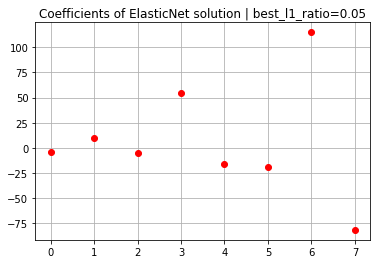

In [43]:
plt.figure()
plt.plot(best_elastic_net_model.coef_, 'ro')
plt.grid()
plt.title("Coefficients of ElasticNet solution | best_l1_ratio={}".format(best_l1_ratio))
plt.show()

In [44]:
if os.path.exists(os.path.join(best_model_path, best_model_name)):
    with open(os.path.join(best_model_path, best_model_name), 'rb') as f:
        dict_pickle_res = pickle.load(f)
        
    df_res.loc["Current saved model ({})".format(dict_pickle_res["best_model"].__class__.__name__), :] = (dict_pickle_res["best_train_cindex"],
                                                                                                          dict_pickle_res["best_val_cindex"],
                                                                                                          dict_pickle_res["best_model"])

In [45]:
df_res

,train_cindex,val_cindex,model
AutoSklearnRegressor,NaN,0.730972,AutoSklearnRegressor(delete_output_folder_afte...
ElasticNet,0.676661,0.712886,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
Current saved model (AutoSklearnRegressor),NaN,0.749435,AutoSklearnRegressor(delete_output_folder_afte...


In [46]:
def plot_accuracies(df, title):
    figure = plt.figure()
    colors = ["r-o", "b-o", "y-o", "g-o", "c-o", "k-o"]
    methods = df.index
    for i, (line, color) in enumerate(zip(df.values, colors)):
        plt.plot(np.arange(len(line)), line, color, label=methods[i])
    plt.ylabel('C-index')
    plt.xticks(np.arange(len(df.columns)),[name for name in df.columns])
    plt.legend(bbox_to_anchor=(1.5, 0.75))
    plt.title(title)
    plt.grid()
    plt.show()

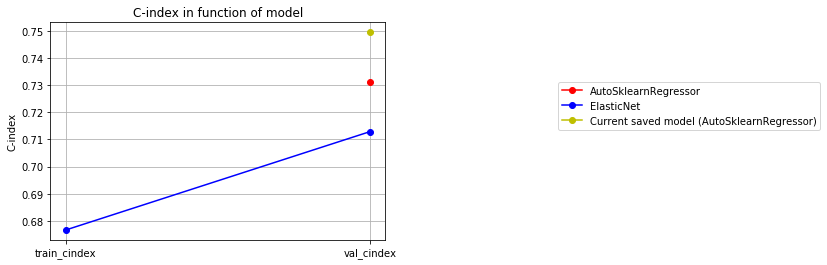

In [47]:
plot_accuracies(df_res.drop(columns=["model"]), "C-index in function of model")

In [48]:
index_best_model = np.argmax(df_res["val_cindex"].values)
best_val_cindex = df_res["val_cindex"].values[index_best_model]
best_train_cindex = df_res["train_cindex"].values[index_best_model]
best_model = df_res["model"][index_best_model]

In [49]:
best_model

AutoSklearnRegressor(delete_output_folder_after_terminate=True,
                     delete_tmp_folder_after_terminate=True,
                     disable_evaluator_output=False, ensemble_memory_limit=1024,
                     ensemble_nbest=50, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configurations_...arning=25,
                     logging_config=None, metadata_directory=None,
                     ml_memory_limit=3072, n_jobs=None, output_folder=None,
                     per_run_time_limit=30,
                     resampling_strategy=<class '__main__.ShuffleSplit'>,
                     resampling_strategy_arguments={'n_splits': 1,
                                                    'random_state': 42,
                                                    'test_size': 0.2},
       

### Test

In [50]:
y_test_pred = best_model.predict(X_test)

### Read random submission example

In [51]:
df_predicted_survival_time = pd.read_csv(os.path.join(submission_example_file_path, "random_submission_0vhlEZN.csv"), index_col=0)
df_predicted_survival_time.head(5)

,SurvivalTime,Event
PatientID,,
13,788.417673,NaN
155,427.650092,NaN
404,173.587222,NaN
407,389.877973,NaN
9,1580.767244,NaN


### Write my test prediction to my submission file

In [52]:
df_predicted_survival_time.index = df_test_clinical_data.index
df_predicted_survival_time["SurvivalTime"] = y_test_pred

In [53]:
df_predicted_survival_time.head(5)

,SurvivalTime,Event
PatientID,,
13,821.954781,NaN
155,871.485964,NaN
404,829.352798,NaN
407,839.379711,NaN
9,864.013339,NaN


In [54]:
df_predicted_survival_time.to_csv(os.path.join(my_submission_path, "submission.csv"))

### Save model

In [55]:
dict_pickle_res = {}
dict_pickle_res["best_train_cindex"] = best_train_cindex
dict_pickle_res["best_val_cindex"] = best_val_cindex
dict_pickle_res["best_model"] = best_model

with open(os.path.join(best_model_path, best_model_name), 'wb') as f:
    pickle.dump(dict_pickle_res, f)

### Load model

(to check if the model was saved properly)

In [56]:
with open(os.path.join(best_model_path, best_model_name), 'rb') as f:
    dict_pickle_res = pickle.load(f)

In [57]:
print("best_train_cindex", dict_pickle_res["best_train_cindex"])
print("best_val_cindex", dict_pickle_res["best_val_cindex"])
print("best_model", dict_pickle_res["best_model"])

best_train_cindex nan
best_val_cindex 0.7494348153673743
best_model AutoSklearnRegressor(delete_output_folder_after_terminate=True,
                     delete_tmp_folder_after_terminate=True,
                     disable_evaluator_output=False, ensemble_memory_limit=1024,
                     ensemble_nbest=50, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configurations_...arning=25,
                     logging_config=None, metadata_directory=None,
                     ml_memory_limit=3072, n_jobs=None, output_folder=None,
                     per_run_time_limit=30,
                     resampling_strategy=<class '__main__.ShuffleSplit'>,
                     resampling_strategy_arguments={'n_splits': 1,
                                                    'random_state': 42,
          

In [58]:
y_test_pred = best_model.predict(X_test)
list(y_test_pred[0:5])

[821.9547814941407,
 871.4859643554688,
 829.3527978515625,
 839.3797106933594,
 864.0133386230469]

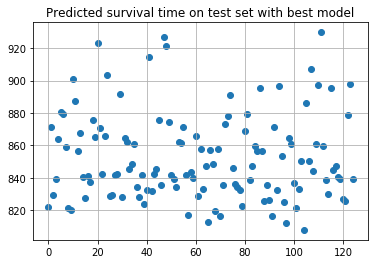

In [59]:
plt.figure()
plt.scatter(np.arange(len(y_test_pred)), y_test_pred)
plt.grid()
plt.title("Predicted survival time on test set with best model")
plt.show()

### Remark

When looking at the plot above, we can see that all the survival times are located between 800 and 930 days which seems surprising. I wonder if the C-index score is a good performance metric.

### CNN for regression with CT scans

[See code on Google Colab (for GPU purposes)]()

### TO DO

- Dense Neural Net for regression
- Choose other variables in the data (clinical_data.csv, radiomics.csv) instead of the ones of the baseline
- Regression on missing ages and histology and then take these variables into account